#Dynamic Daily Task Scheduling Simulation: A Harmonic Swarm Optimization Approach


### Table of Contents

1. **Introduction and Overview**  
   Overview of the simulation, its purpose, and a brief description of edge cases.

2. **Setup and Imports**  
   Importing necessary libraries and setting random seeds.

3. **Global Variables and Simulation Parameters**  
   Defining day duration, time steps, parts-of-day windows, and global variables.

4. **Helper Functions: update_task_priority and update_allowed_window**  
   Functions to dynamically update task priority and allowed time windows.

5. **Objective Function: dynamic_objective_function**  
   The cost function that penalizes unschedulable, out-of-window, or late tasks.

6. **Optimization Algorithm: dynamic_harmonic_swarm_optimizer**  
   The swarm optimizer that incorporates harmonic adjustments and multiple layers of randomness.

7. **Simulation Function: simulate_dynamic_scheduling_with_time_windows**  
   The main function that simulates a day of dynamic task arrivals and scheduling.

8. **Logging, Reporting, and Final Output**  
   How logs are stored, flattened, and exported for reporting.

9. **References and Acknowledgements**  
   Credits and references to external sources.

## Section 1: Introduction and Overview

In this notebook, we simulate a dynamic scheduling system for a single day. The simulation generates tasks that arrive throughout the day with various constraints and allowed time windows (like office hours, morning, afternoon, or evening). The optimizer uses a harmonic swarm intelligence approach that incorporates multiple sources of randomness to explore a complex solution space.  
  
**Key Points Covered:**

- **Edge Cases Handled:**
  - Infeasible time constraints (e.g., task arrival after its deadline or duration exceeding its allowed window).
  - Conflicting or overlapping allowed windows.
  - Boundary issues for tasks near the end of the day.
  - Rapid or bursty task arrivals.
  - Dynamic changes such as shifting allowed windows and rapid priority fluctuations.

- **Goal:**  
  To schedule tasks as they arrive while respecting their allowed windows and deadlines, and to log detailed simulation data for later analysis.

Below is an introductory cell that explains the overall purpose:

```python
# Introduction and Overview

"""
This notebook simulates a dynamic daily scheduling system.
It generates tasks with random properties such as arrival time, duration,
deadline, and allowed time windows (e.g., office hours, morning, etc.).
The system uses a harmonic swarm optimizer to continuously adjust task start times,
handling various edge cases like unschedulable tasks, conflicting windows, and bursty arrivals.
Detailed logs are maintained for extensive reporting and analysis.

Edge Cases Covered:
1. Infeasible Time Constraints (arrival after deadline, duration too long)
2. Conflicting or Overlapping Allowed Windows
3. Boundary and End-of-Day Issues
5. Rapid or Bursty Task Arrivals
6. Dynamic Changes (priority fluctuations, shifting allowed windows)

Thanks to Richard Aragon for inspiration and demonstration:
- Colab Notebook: https://colab.research.google.com/drive/1RZKTQv0V01ExenZL0MyHgoCYyLQE7Lj3
- Video: https://www.youtube.com/watch?v=cvNzwlLyKbg
"""
```

## Section 2: Setup and Imports

In this section, we import the required libraries and set random seeds to ensure reproducibility (which you may modify for more unpredictability). These imports are essential for numerical operations (NumPy), randomness (random), and data handling (Pandas).



In [1]:
# Setup and Imports

import numpy as np
import random
import pandas as pd

# Set seeds for reproducibility (remove or adjust for more variability)
np.random.seed(42)
random.seed(42)


## Section 3: Global Variables and Simulation Parameters

In this section, we define key simulation parameters and global variables that will govern our simulation. These include:

- **`day_hours`:** Total duration of the simulation day (24 hours).
- **`time_step`:** The time resolution for each simulation step (0.5 hours).
- **`num_steps`:** Computed number of simulation steps based on the time resolution.
- **`parts_of_day`:** Pre-defined time windows (office hours, morning, afternoon, evening) used to assign allowed scheduling windows to tasks.
- **Global Variables:**  
  - **`tasks`:** A list to store all the dynamically generated tasks.
  - **`simulation_logs`:** A list to record detailed logs at each simulation time step for later reporting.

In [2]:
# Global Variables and Simulation Parameters

# Total simulation time in hours for a single day
day_hours = 24  # 24 hours in a day

# Simulation time resolution: Each time step represents 0.5 hours
time_step = 0.5

# Calculate the number of simulation steps for the day
num_steps = int(day_hours / time_step)

# Define parts-of-day windows used to assign allowed time slots for tasks.
parts_of_day = {
    "office_hours": (9.0, 17.0),   # Typical office hours
    "morning": (6.0, 9.0),         # Early morning window
    "afternoon": (17.0, 20.0),     # Late afternoon to early evening
    "evening": (20.0, 23.0)        # Evening window
}

# Global lists for storing tasks and simulation logs
tasks = []              # To store dynamically generated task dictionaries
simulation_logs = []    # To record logs for each simulation time step


## Section 4: Helper Functions – update_task_priority and update_allowed_window

In this section, we define two helper functions that help update the dynamic properties of our tasks as the simulation progresses.

### 4.1 `update_task_priority`
This function recalculates the priority of a task based on how close the current simulation time is to the task's deadline. The closer the time is to the deadline, the higher the urgency becomes. A small random factor is applied to simulate unpredictable shifts in urgency.

### 4.2 `update_allowed_window`
This function introduces a dynamic element to the allowed time window of a task. With a small probability (10%), a task’s allowed window (which represents a part of the day like office hours or morning) is updated. This mimics scenarios such as rescheduling a meeting or a task's time preference shifting unexpectedly.

In [3]:
def update_task_priority(task, current_time):
    """
    Update a task's priority based on its urgency.

    Parameters:
      task (dict): A task dictionary containing 'arrival_time', 'deadline',
                   'base_priority', and current 'priority'.
      current_time (float): The current simulation time.

    Returns:
      Updated task with a new 'priority' value.
    """
    if task['deadline'] > task['arrival_time']:
        # Calculate basic urgency as the fraction of elapsed time over the total time window.
        urgency = (current_time - task['arrival_time']) / (task['deadline'] - task['arrival_time'] + 1e-6)
        # Include a small random factor to simulate variability in urgency.
        random_urgency_factor = np.random.uniform(0.9, 1.1)
        task['priority'] = task['base_priority'] * (1 + urgency * random_urgency_factor)
    return task

def update_allowed_window(task):
    """
    With a small probability, update the allowed window for a task to simulate dynamic changes.
    For example, a meeting might be rescheduled to a different part of the day.

    Parameters:
      task (dict): A task dictionary that includes 'allowed_window' and 'part_of_day'.

    Returns:
      Updated task dictionary with possibly new allowed window settings.
    """
    if random.random() < 0.1:  # 10% chance to update the allowed window
        new_part = random.choice(list(parts_of_day.keys()))
        task['allowed_window'] = parts_of_day[new_part]
        task['part_of_day'] = new_part
    return task


## Section 5: Objective Function – dynamic_objective_function

This section defines the objective (or cost) function that evaluates the quality of a candidate schedule. The function computes a total cost by aggregating penalties for each task based on various conditions:

- **Scheduling before Arrival:**  
  A heavy penalty is added if a task is scheduled to start before its arrival time.

- **Finishing After Deadline:**  
  If a task finishes after its deadline, a penalty proportional to the task's dynamic priority is applied.

- **Scheduling Outside Allowed Window:**  
  Tasks that are scheduled outside their designated allowed window (for example, office hours) incur a significant penalty.

- **Edge Case Handling:**  
  - If a task's arrival time is later than its deadline, a very high penalty is imposed since the task is unschedulable.
  - If a task's duration exceeds the time available in its allowed window, it also receives a high penalty.
  - Tasks arriving very late in the day get an additional penalty.

In [4]:
def dynamic_objective_function(schedule, tasks, current_time):
    """
    Calculate the total cost of a candidate schedule.

    This function penalizes:
      - Scheduling a task before its arrival.
      - Finishing a task after its deadline.
      - Scheduling a task outside its allowed time window.
      - Infeasible time constraints such as arrival after deadline or duration exceeding allowed window.

    Parameters:
      schedule (array): Proposed start times for each task.
      tasks (list): List of task dictionaries.
      current_time (float): The current simulation time.

    Returns:
      total_cost (float): The aggregate cost of the schedule.
    """
    total_cost = 0.0
    for i, task in enumerate(tasks):
        start_time = schedule[i]

        # Edge Case 1: Infeasible time constraint: arrival after deadline.
        if task['arrival_time'] > task['deadline']:
            total_cost += 10000  # Very high penalty for unschedulable task.
            continue

        # Edge Case 1: Duration exceeds allowed window (if specified).
        if 'allowed_window' in task:
            window_start, window_end = task['allowed_window']
            if task['duration'] > (window_end - window_start):
                total_cost += 10000  # Infeasible to schedule within allowed window.

        # Edge Case 3: Task arriving very late in the day.
        if task['arrival_time'] > day_hours - 1:
            total_cost += 500  # Penalty for tasks arriving very late.

        # Penalty for scheduling before the task's arrival.
        if start_time < task['arrival_time']:
            total_cost += 1000 * (task['arrival_time'] - start_time)
            start_time = task['arrival_time']

        finish_time = start_time + task['duration']
        lateness = max(0, finish_time - task['deadline'])
        total_cost += task['priority'] * lateness

        # Edge Case 2: Penalty for scheduling outside the allowed window.
        if 'allowed_window' in task:
            window_start, window_end = task['allowed_window']
            if start_time < window_start:
                total_cost += 1000 * (window_start - start_time)
            elif start_time > window_end:
                total_cost += 1000 * (start_time - window_end)

    return total_cost

## Section 6: Optimization Algorithm – dynamic_harmonic_swarm_optimizer

This section presents the core optimization algorithm of the simulation: the harmonic swarm optimizer. This function searches for optimal task start times using a combination of deterministic harmonic adjustments and multiple layers of randomness to navigate the complex solution space.

**Key Components:**

- **Initialization:**  
  The optimizer initializes a swarm of candidate schedules (each a vector of start times) uniformly over the valid time window (from the current simulation time to the end of the day).

- **Harmonic Adjustment:**  
  A sinusoidal (harmonic) adjustment is applied to guide the candidates during each iteration, providing a deterministic component to the search.

- **Random Noise:**  
  Normally distributed noise is added to each candidate solution to encourage exploration and help escape local minima.

- **Random Scaling:**  
  Each candidate is multiplied by a random scaling factor (uniformly drawn) to further diversify the solutions.

- **Clipping:**  
  Candidate start times are clipped to ensure they remain within the valid scheduling window.


In [5]:
def dynamic_harmonic_swarm_optimizer(obj_func, tasks, current_time, swarm_size, iteration_count, harmonic_amplitude, harmonic_frequency):
    """
    A harmonic swarm optimizer that uses several layers of randomness to search for optimal start times.

    Parameters:
      obj_func (function): The objective function to minimize.
      tasks (list): List of task dictionaries.
      current_time (float): The current simulation time.
      swarm_size (int): Number of candidate solutions in the swarm.
      iteration_count (int): Number of iterations to run the optimizer.
      harmonic_amplitude (float): Amplitude for the harmonic (sinusoidal) adjustment.
      harmonic_frequency (float): Frequency of the harmonic modulation.

    Returns:
      best_solution (array): The candidate schedule (start times) with the lowest cost.
      best_cost (float): The cost associated with the best solution.
    """
    num_tasks = len(tasks)
    lower_bound = current_time
    upper_bound = day_hours
    # Initialize candidate solutions uniformly within the allowed time window.
    swarm = np.random.uniform(low=lower_bound, high=upper_bound, size=(swarm_size, num_tasks))

    best_solution = None
    best_cost = float('inf')

    for iteration in range(iteration_count):
        # Evaluate each candidate schedule in the swarm.
        for candidate in swarm:
            cost = obj_func(candidate, tasks, current_time)
            if cost < best_cost:
                best_cost = cost
                best_solution = candidate.copy()

        # Apply a deterministic harmonic adjustment.
        harmonic_adjustment = harmonic_amplitude * np.sin(harmonic_frequency * iteration)
        swarm += harmonic_adjustment

        # Add normally distributed random noise.
        noise = np.random.normal(loc=0.0, scale=0.7, size=swarm.shape)
        swarm += noise

        # Multiply each candidate by a random scaling factor to diversify the update.
        random_scaling = np.random.uniform(0.8, 1.2, size=swarm.shape)
        swarm *= random_scaling

        # Clip the candidate solutions to ensure they remain within [current_time, day_hours].
        swarm = np.clip(swarm, lower_bound, upper_bound)

    return best_solution, best_cost


## Section 7: Simulation Function – simulate_dynamic_scheduling_with_time_windows

In this section, we implement the main simulation function that ties together all components. This function simulates a full day of scheduling where:

- **Dynamic Task Generation:**  
  New tasks are generated at each time step with random properties (arrival time, duration, deadline, base priority) and are assigned an allowed window (e.g., office_hours, morning, etc.). Occasionally, a burst of tasks is introduced to simulate high density.

- **Dynamic Updates:**  
  Existing tasks update their priority as time advances, and with a small probability, their allowed time window may change to simulate rescheduling.

- **Task Removal:**  
  Tasks that become overdue are removed from the active task list.

- **Optimization:**  
  At each time step, the optimizer computes an optimal schedule for all current tasks using the dynamic harmonic swarm optimizer.

- **Logging:**  
  Detailed logs are stored at each simulation step, including task details and scheduling decisions. These logs are later flattened and saved to a CSV file for expansive reporting and analysis.

In [6]:
def simulate_dynamic_scheduling_with_time_windows():
    """
    Simulate a full day with dynamically arriving tasks and allowed time windows.
    Incorporates edge cases such as infeasible time constraints, conflicting windows,
    boundary issues, bursty arrivals, and dynamic changes.

    Detailed logs are recorded for each simulation step for further reporting.
    """
    current_time = 0.0
    simulation_end = day_hours
    swarm_size = 50
    iteration_count = 100
    harmonic_amplitude = 0.5
    harmonic_frequency = 1.0

    global tasks
    tasks = []  # Reset tasks at the start

    for step in range(num_steps):
        current_time = round(step * time_step, 1)
        print(f"\n--- Simulation Time: {current_time:.1f}h ---")

        # Remove overdue tasks (simulate cancellation if too late).
        margin = 1.0  # Allow a 1-hour margin past the deadline.
        tasks = [task for task in tasks if current_time <= task['deadline'] + margin]

        # Update priorities and possibly update allowed windows for existing tasks.
        for task in tasks:
            update_task_priority(task, current_time)
            update_allowed_window(task)

        # Edge Case 5: Rapid or bursty task arrivals.
        new_tasks_this_step = []
        # With a lower probability, generate a burst (4 to 6 tasks); otherwise, normal mode.
        if random.random() < 0.2:
            num_new_tasks = random.randint(4, 6)
        elif random.random() < 0.7:
            num_new_tasks = random.randint(1, 3)
        else:
            num_new_tasks = 0

        for _ in range(num_new_tasks):
            duration = round(random.uniform(0.5, 2.5), 1)
            deadline = round(random.uniform(current_time + duration, min(day_hours, current_time + duration + 6)), 1)
            base_priority = round(random.uniform(1.0, 4.0), 1)
            # Determine allowed window: 70% chance the task is an office task,
            # otherwise randomly pick a different part-of-day.
            if random.random() < 0.7:
                allowed_window = parts_of_day["office_hours"]
                part_of_day = "office_hours"
            else:
                part_of_day = random.choice([k for k in parts_of_day if k != "office_hours"])
                allowed_window = parts_of_day[part_of_day]

            # Edge Case 1: Introduce potential infeasibility occasionally.
            # With 10% chance, set arrival time after deadline.
            if random.random() < 0.1:
                arrival_time = round(random.uniform(deadline + 0.1, day_hours), 1)
            else:
                arrival_time = current_time

            new_task = {
                'arrival_time': arrival_time,
                'duration': duration,
                'deadline': deadline,
                'priority': base_priority,
                'base_priority': base_priority,
                'allowed_window': allowed_window,
                'part_of_day': part_of_day
            }
            tasks.append(new_task)
            new_tasks_this_step.append(new_task)
            print("New task added:", new_task)

        # If there are tasks waiting, run the optimizer.
        if tasks:
            best_schedule, best_cost = dynamic_harmonic_swarm_optimizer(
                dynamic_objective_function,
                tasks,
                current_time,
                swarm_size,
                iteration_count,
                harmonic_amplitude,
                harmonic_frequency
            )

            # Log detailed information for each task.
            log_entries = []
            for i, task in enumerate(tasks):
                scheduled_start = round(best_schedule[i], 2) if best_schedule is not None else None
                cost_contribution = task['priority'] * max(0, (scheduled_start + task['duration'] - task['deadline'])) if scheduled_start is not None else None
                log_entry = {
                    'time': current_time,
                    'task_id': i,
                    'arrival_time': task['arrival_time'],
                    'duration': task['duration'],
                    'deadline': task['deadline'],
                    'allowed_window': task['allowed_window'],
                    'part_of_day': task['part_of_day'],
                    'scheduled_start': scheduled_start,
                    'priority': task['priority'],
                    'cost_contribution': cost_contribution
                }
                log_entries.append(log_entry)
                print(f"Task {i}: Arrival {task['arrival_time']}h, Duration {task['duration']}h, Deadline {task['deadline']}h, "
                      f"Allowed window {task['allowed_window']}, Scheduled start {scheduled_start}h, Priority {task['priority']:.2f}")
            print("Aggregate cost:", best_cost)

            simulation_logs.append({
                'time': current_time,
                'num_tasks': len(tasks),
                'new_tasks': new_tasks_this_step,
                'best_schedule': best_schedule.tolist() if best_schedule is not None else None,
                'aggregate_cost': best_cost,
                'task_logs': log_entries
            })
        else:
            print("No tasks to schedule at this time.")
            simulation_logs.append({
                'time': current_time,
                'num_tasks': 0,
                'new_tasks': [],
                'best_schedule': None,
                'aggregate_cost': None,
                'task_logs': []
            })

    # Flatten logs for comprehensive reporting.
    flat_logs = []
    for log in simulation_logs:
        for task_log in log['task_logs']:
            flat_entry = {
                'time': log['time'],
                'task_id': task_log['task_id'],
                'arrival_time': task_log['arrival_time'],
                'duration': task_log['duration'],
                'deadline': task_log['deadline'],
                'allowed_window': task_log['allowed_window'],
                'part_of_day': task_log['part_of_day'],
                'scheduled_start': task_log['scheduled_start'],
                'priority': task_log['priority'],
                'cost_contribution': task_log['cost_contribution'],
                'aggregate_cost': log['aggregate_cost']
            }
            flat_logs.append(flat_entry)

    df_logs = pd.DataFrame(flat_logs)
    df_logs.to_csv("dynamic_scheduling_with_time_windows_logs.csv", index=False)
    print("\nSimulation complete. Logs saved to 'dynamic_scheduling_with_time_windows_logs.csv'.")
    return df_logs


## Section 8: Logging, Reporting, and Final Output

In this final section, we take the detailed logs recorded during the simulation and prepare them for analysis and reporting. The logs have been flattened and saved as a CSV file (`dynamic_scheduling_with_time_windows_logs.csv`), which you can open later in any tool that supports CSV files (like Excel or Pandas).  

For convenience, we also generate a summary report directly in the notebook. In this example, we group the log data by simulation time and calculate summary statistics such as the minimum, maximum, and mean aggregate cost, as well as the average priority of tasks. This report provides insight into how the scheduling performance evolves over the course of the day.

In [7]:
# Logging, Reporting, and Final Output

# The simulation logs have been flattened and saved to 'dynamic_scheduling_with_time_windows_logs.csv'.
# For reporting, we can load the logs into a Pandas DataFrame (if not already in memory) and generate summary statistics.
# (If running in the same notebook session, df_logs is already available.)

# Load the simulation logs from the CSV file into a Pandas DataFrame.
df_simulation_logs = simulate_dynamic_scheduling_with_time_windows()

# Example report: Generate summary statistics grouped by simulation time.
report = df_simulation_logs.groupby('time').agg({
    'aggregate_cost': ['min', 'max', 'mean'],
    'priority': ['mean']
}).reset_index()

print("\nSummary Report by Simulation Time:")
print(report)

# Optionally, display the full DataFrame of logs.
# df_simulation_logs.head()  # Uncomment to see the first few rows.



--- Simulation Time: 0.0h ---
New task added: {'arrival_time': 11.2, 'duration': 1.0, 'deadline': 1.8, 'priority': 1.3, 'base_priority': 1.3, 'allowed_window': (20.0, 23.0), 'part_of_day': 'evening'}
New task added: {'arrival_time': 0.0, 'duration': 0.6, 'deadline': 1.9, 'priority': 2.5, 'base_priority': 2.5, 'allowed_window': (9.0, 17.0), 'part_of_day': 'office_hours'}
Task 0: Arrival 11.2h, Duration 1.0h, Deadline 1.8h, Allowed window (20.0, 23.0), Scheduled start 4.88h, Priority 1.30
Task 1: Arrival 0.0h, Duration 0.6h, Deadline 1.9h, Allowed window (9.0, 17.0), Scheduled start 9.0h, Priority 2.50
Aggregate cost: 10019.252052858588

--- Simulation Time: 0.5h ---
New task added: {'arrival_time': 0.5, 'duration': 2.0, 'deadline': 3.5, 'priority': 2.3, 'base_priority': 2.3, 'allowed_window': (9.0, 17.0), 'part_of_day': 'office_hours'}
Task 0: Arrival 11.2h, Duration 1.0h, Deadline 1.8h, Allowed window (20.0, 23.0), Scheduled start 15.61h, Priority 1.30
Task 1: Arrival 0.0h, Duration 0

### Table of Contents for Actionable Metrics

1. **Introduction to Actionable Metrics**  
2. **Aggregate Cost / Objective Value**  
3. **Lateness Metrics (Average & Maximum Lateness)**  
4. **Scheduling Within Allowed Window Percentage**  
5. **Task Deadline Violation Rate**  
6. **Arrival-to-Scheduling Delay**  
7. **Resource Utilization Rate**  
8. **Task Rejection/Cancellation Rate**  
9. **Convergence & Swarm Diversity Metrics**  
10. **Task Priority Distribution and Cost Contribution**  
11. **Scheduling Stability and Impact of Bursty Arrivals**  
12. **Allowed Window Violation Frequency**  
13. **Optimization Computation Time & System Responsiveness**  
14. **Conclusion and Next Steps**

---

When you’re ready, we’ll begin with **Section 1: Introduction to Actionable Metrics**.

---

## Section 1: Introduction to Actionable Metrics

In this section, we introduce the concept of actionable metrics for our dynamic scheduling system. These metrics help us monitor performance, assess scheduling quality, and identify opportunities for improvement. We’ll later use our simulation logs (stored in a Pandas DataFrame) to calculate these metrics.

## Section 2: Aggregate Cost / Objective Value

In this section, we analyze the **Aggregate Cost** metric. The aggregate cost represents the overall penalty incurred by the schedule at each simulation time step, as computed by our objective function. A lower aggregate cost indicates a more effective schedule. Tracking this metric over time allows us to monitor the overall performance and identify trends or anomalies in scheduling quality.

Below is the code to calculate and visualize the Aggregate Cost from our simulation logs stored in the Pandas DataFrame (`df_simulation_logs`):

Aggregate Cost by Time:
    time  aggregate_cost
0    0.0    10019.252053
1    0.5    10042.882519
2    1.0    30050.212278
3    1.5    30060.709175
4    2.0    31068.250820
5    2.5    30168.036918
6    3.0    22659.114079
7    3.5    21222.413111
8    4.0    38145.537561
9    4.5    39423.723551
10   5.0    40488.667730
11   5.5    45930.214081
12   6.0    49556.745117
13   6.5    56372.018471
14   7.0    50188.770267
15   7.5    44055.156664
16   8.0    59062.779419
17   8.5    46817.922283
18   9.0    31782.902260
19   9.5    29693.936893
20  10.0    33839.170214
21  10.5    35561.255256
22  11.0    32928.267627
23  11.5    40716.669597
24  12.0    48244.571657
25  12.5    49208.232072
26  13.0    61276.715782
27  13.5    57841.002020
28  14.0    44098.333357
29  14.5    49046.774306
30  15.0    47780.476905
31  15.5    37147.543192
32  16.0    45283.736055
33  16.5    48997.949493
34  17.0    38120.603084
35  17.5    54861.460166
36  18.0    59195.078332
37  18.5    82147.396373
3

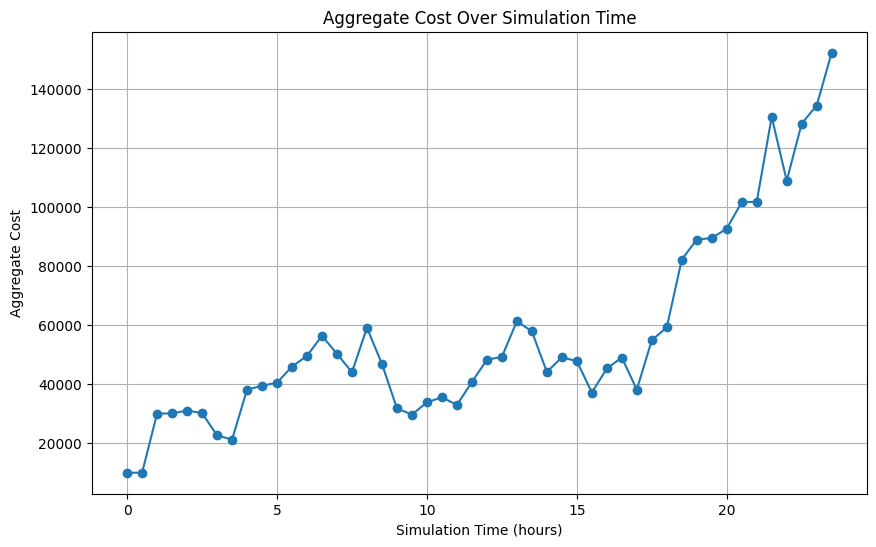

In [8]:
# Section 2: Aggregate Cost / Objective Value

import matplotlib.pyplot as plt

# Calculate the average aggregate cost per simulation time step.
aggregate_cost_by_time = df_simulation_logs.groupby('time')['aggregate_cost'].mean().reset_index()

print("Aggregate Cost by Time:")
print(aggregate_cost_by_time)

# Plot the aggregate cost over simulation time.
plt.figure(figsize=(10, 6))
plt.plot(aggregate_cost_by_time['time'], aggregate_cost_by_time['aggregate_cost'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Aggregate Cost')
plt.title('Aggregate Cost Over Simulation Time')
plt.grid(True)
plt.show()


## Section 3: Lateness Metrics (Average & Maximum Lateness)

In this section, we evaluate task lateness metrics. **Lateness** for a task is defined as the delay beyond its deadline, calculated as:

\[
\text{lateness} = \max(0, \text{scheduled\_start} + \text{duration} - \text{deadline})
\]

We compute two key metrics from this:
- **Average Lateness:** The mean lateness across tasks at each simulation time step.
- **Maximum Lateness:** The worst-case (maximum) lateness experienced by any task in a given time step.

Lateness Metrics by Time:
    time  avg_lateness  max_lateness
0    0.0      5.890000          7.70
1    0.5     10.226667         14.81
2    1.0      4.798000          7.86
3    1.5      4.706000          7.88
4    2.0      7.620000         13.57
5    2.5      5.574545         10.09
6    3.0      7.995556         15.78
7    3.5      7.680000         11.87
8    4.0      5.536667         17.41
9    4.5      9.025000         14.99
10   5.0      7.522353         17.70
11   5.5      5.938000         15.12
12   6.0      6.684737         15.38
13   6.5      6.463182         17.14
14   7.0      8.195652         19.00
15   7.5      5.012609         13.97
16   8.0      7.287391         18.60
17   8.5      4.990476         16.50
18   9.0      6.597000         15.41
19   9.5      4.729048         11.99
20  10.0      4.408095         12.98
21  10.5      3.566957         12.90
22  11.0      2.304167          9.40
23  11.5      2.829600          9.24
24  12.0      3.477600         11.20
25  12.5    

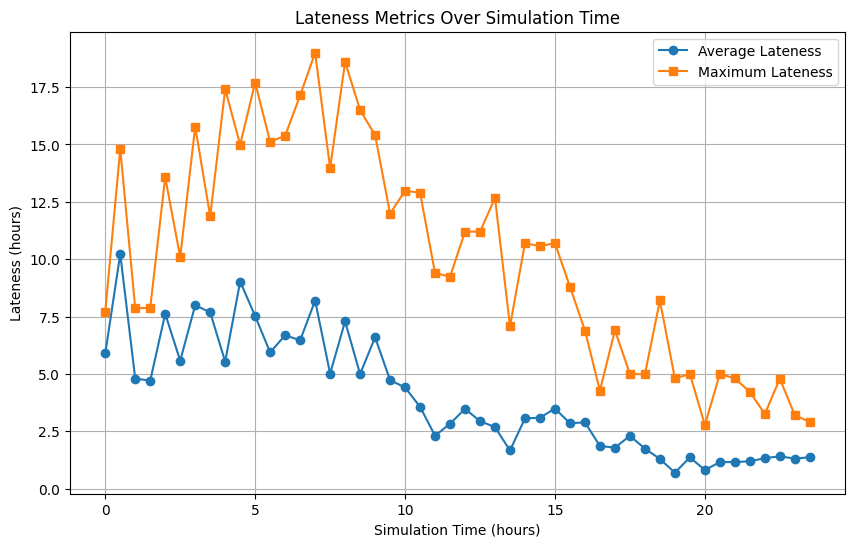

In [9]:
# Section 3: Lateness Metrics (Average & Maximum Lateness)

# First, calculate lateness for each task in the logs
# lateness = max(0, scheduled_start + duration - deadline)
df_simulation_logs['lateness'] = df_simulation_logs.apply(
    lambda row: max(0, row['scheduled_start'] + row['duration'] - row['deadline']), axis=1)

# Group by simulation time to calculate average and maximum lateness at each time step
lateness_metrics = df_simulation_logs.groupby('time').agg(
    avg_lateness=('lateness', 'mean'),
    max_lateness=('lateness', 'max')
).reset_index()

print("Lateness Metrics by Time:")
print(lateness_metrics)

# Plotting Average and Maximum Lateness over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lateness_metrics['time'], lateness_metrics['avg_lateness'], marker='o', label='Average Lateness')
plt.plot(lateness_metrics['time'], lateness_metrics['max_lateness'], marker='s', label='Maximum Lateness')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Lateness (hours)')
plt.title('Lateness Metrics Over Simulation Time')
plt.legend()
plt.grid(True)
plt.show()


## Section 4: Scheduling Within Allowed Window Percentage

In this section, we evaluate how well the scheduler adheres to the allowed time windows for tasks. This metric calculates the percentage of tasks scheduled to start within their designated allowed window (for instance, office hours, morning, etc.). A higher percentage indicates that the scheduler is effectively respecting the constraints imposed by the allowed windows.

### Explanation:
- **Allowed Window Compliance:**  
  For each task, we check whether the scheduled start time falls within its allowed window.
- **Metric Calculation:**  
  We compute the ratio of tasks scheduled within their allowed window to the total number of tasks at each simulation time step. This gives us a percentage that can be tracked over time.

Allowed Window Metrics by Time:
    time  percentage_within_window
0    0.0                 50.000000
1    0.5                 66.666667
2    1.0                 40.000000
3    1.5                 40.000000
4    2.0                 54.545455
5    2.5                 72.727273
6    3.0                 44.444444
7    3.5                 66.666667
8    4.0                 40.000000
9    4.5                 56.250000
10   5.0                 35.294118
11   5.5                 35.000000
12   6.0                 63.157895
13   6.5                 27.272727
14   7.0                 34.782609
15   7.5                 43.478261
16   8.0                 34.782609
17   8.5                 52.380952
18   9.0                 55.000000
19   9.5                 52.380952
20  10.0                 47.619048
21  10.5                 56.521739
22  11.0                 58.333333
23  11.5                 48.000000
24  12.0                 48.000000
25  12.5                 41.666667
26  13.0               

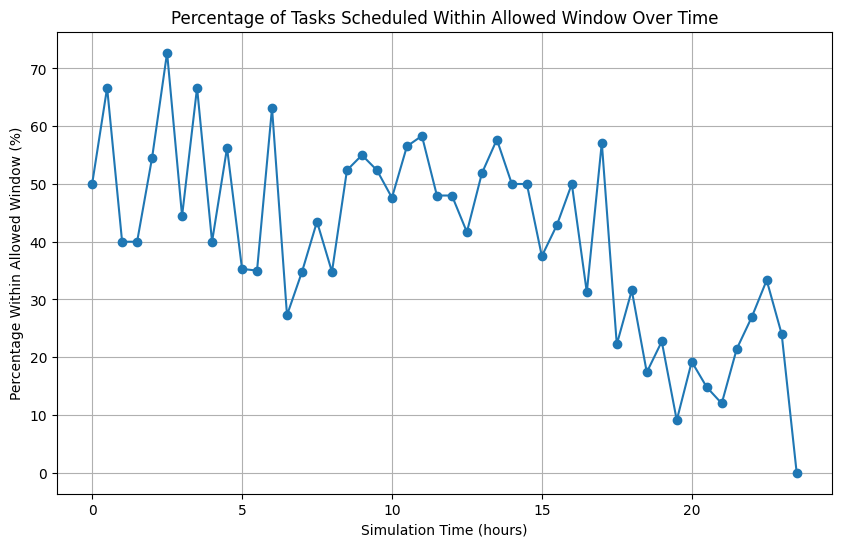

In [10]:
# Section 4: Scheduling Within Allowed Window Percentage

def is_within_allowed_window(row):
    """
    Check if the task's scheduled start time falls within its allowed window.
    Returns 1 if yes, 0 otherwise.
    """
    if 'allowed_window' in row and row['scheduled_start'] is not None:
        window_start, window_end = row['allowed_window']
        return 1 if window_start <= row['scheduled_start'] <= window_end else 0
    return 0

# Apply the function to each row to create a new column indicating allowed window compliance.
df_simulation_logs['within_allowed_window'] = df_simulation_logs.apply(is_within_allowed_window, axis=1)

# Calculate the percentage of tasks scheduled within their allowed window for each simulation time step.
allowed_window_metrics = df_simulation_logs.groupby('time').agg(
    total_tasks=('task_id', 'count'),
    tasks_within_window=('within_allowed_window', 'sum')
).reset_index()

allowed_window_metrics['percentage_within_window'] = (allowed_window_metrics['tasks_within_window'] /
                                                      allowed_window_metrics['total_tasks']) * 100

print("Allowed Window Metrics by Time:")
print(allowed_window_metrics[['time', 'percentage_within_window']])

# Plot the percentage of tasks scheduled within their allowed window over time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(allowed_window_metrics['time'], allowed_window_metrics['percentage_within_window'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Percentage Within Allowed Window (%)')
plt.title('Percentage of Tasks Scheduled Within Allowed Window Over Time')
plt.grid(True)
plt.show()


## Section 5: Task Deadline Violation Rate

In this section, we measure the **Task Deadline Violation Rate** – the proportion of tasks that finish after their deadline at each simulation time step. This metric is crucial because it indicates how often tasks are not completed on time, suggesting potential issues with scheduling efficiency or overly stringent constraints.

### Explanation:
- **Deadline Violation:**  
  A task is considered to violate its deadline if the sum of its scheduled start time and duration exceeds its deadline.
- **Metric Calculation:**  
  For each simulation time step, we compute the ratio of tasks with deadline violations to the total number of tasks. Tracking this ratio helps in understanding the overall timeliness of the schedule and informs adjustments to priorities, penalties, or scheduling frequency.

Deadline Violation Metrics by Time:
    time  violation_rate
0    0.0      100.000000
1    0.5      100.000000
2    1.0       80.000000
3    1.5      100.000000
4    2.0       90.909091
5    2.5       90.909091
6    3.0      100.000000
7    3.5      100.000000
8    4.0       93.333333
9    4.5      100.000000
10   5.0       94.117647
11   5.5       90.000000
12   6.0       94.736842
13   6.5       86.363636
14   7.0       95.652174
15   7.5       86.956522
16   8.0      100.000000
17   8.5       76.190476
18   9.0       95.000000
19   9.5       76.190476
20  10.0       80.952381
21  10.5       69.565217
22  11.0       66.666667
23  11.5       68.000000
24  12.0       80.000000
25  12.5       75.000000
26  13.0       77.777778
27  13.5       61.538462
28  14.0       92.307692
29  14.5       82.142857
30  15.0       83.333333
31  15.5       80.952381
32  16.0       80.000000
33  16.5       81.250000
34  17.0       71.428571
35  17.5       72.222222
36  18.0       63.157895
37  18.5      

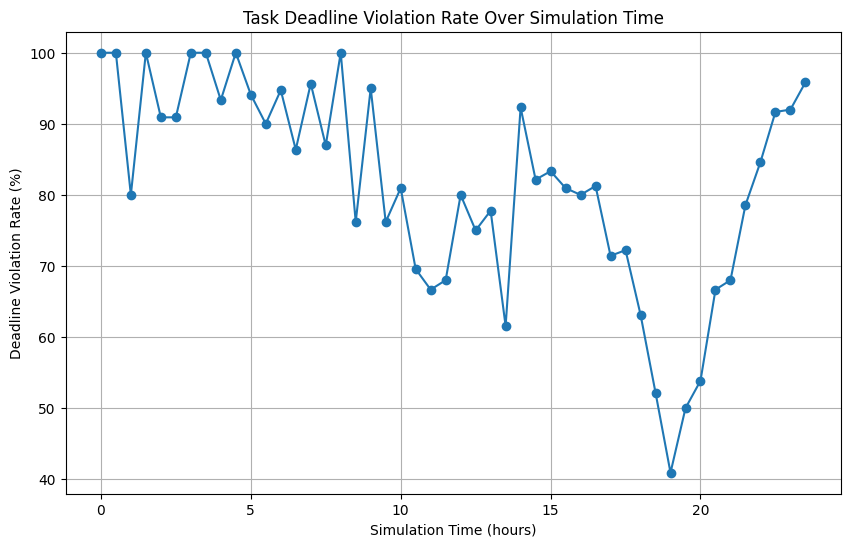

In [11]:
# Section 5: Task Deadline Violation Rate

# Create a new column that flags whether a task violates its deadline.
# A violation occurs if scheduled_start + duration > deadline.
df_simulation_logs['deadline_violation'] = df_simulation_logs.apply(
    lambda row: 1 if row['scheduled_start'] is not None and (row['scheduled_start'] + row['duration'] > row['deadline']) else 0, axis=1)

# Calculate the violation rate for each simulation time step.
violation_metrics = df_simulation_logs.groupby('time').agg(
    total_tasks=('task_id', 'count'),
    total_violations=('deadline_violation', 'sum')
).reset_index()

violation_metrics['violation_rate'] = (violation_metrics['total_violations'] / violation_metrics['total_tasks']) * 100

print("Deadline Violation Metrics by Time:")
print(violation_metrics[['time', 'violation_rate']])

# Plot the Deadline Violation Rate over simulation time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(violation_metrics['time'], violation_metrics['violation_rate'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Deadline Violation Rate (%)')
plt.title('Task Deadline Violation Rate Over Simulation Time')
plt.grid(True)
plt.show()


## Section 6: Arrival-to-Scheduling Delay

In this section, we measure the **Arrival-to-Scheduling Delay** – the average time between when a task is generated (arrival) and when it is scheduled to start. This metric indicates how responsive the scheduling system is to newly arriving tasks.

### Explanation:
- **Arrival-to-Scheduling Delay:**  
  For each task, the delay is computed as:
  \[
  \text{delay} = \text{scheduled\_start} - \text{arrival\_time}
  \]
  A lower delay means that tasks are being scheduled promptly after they arrive.
- **Metric Calculation:**  
  We compute the average delay across tasks for each simulation time step to evaluate the system's responsiveness over time.

Arrival-to-Scheduling Delay Metrics by Time:
    time  avg_delay
0    0.0   1.340000
1    0.5   7.526667
2    1.0  -1.036000
3    1.5  -0.774000
4    2.0   6.800909
5    2.5   4.742727
6    3.0   8.017778
7    3.5   7.702222
8    4.0   5.596667
9    4.5   9.393750
10   5.0   8.100588
11   5.5   6.848000
12   6.0   7.592105
13   6.5   7.484545
14   7.0   9.666522
15   7.5   6.406087
16   8.0   8.948261
17   8.5   6.425238
18   9.0   8.607000
19   9.5   7.223333
20  10.0   7.889524
21  10.5   5.697391
22  11.0   4.732500
23  11.5   4.931600
24  12.0   5.757200
25  12.5   5.191667
26  13.0   5.180370
27  13.5   4.021154
28  14.0   5.747308
29  14.5   5.771429
30  15.0   6.087500
31  15.5   5.690476
32  16.0   5.803500
33  16.5   4.833750
34  17.0   4.607857
35  17.5   4.529444
36  18.0   3.756316
37  18.5   3.202174
38  19.0   1.970455
39  19.5   3.112727
40  20.0   2.110769
41  20.5   2.640370
42  21.0   2.560000
43  21.5   2.376786
44  22.0   2.675769
45  22.5   2.657917
46  23.0   2.17

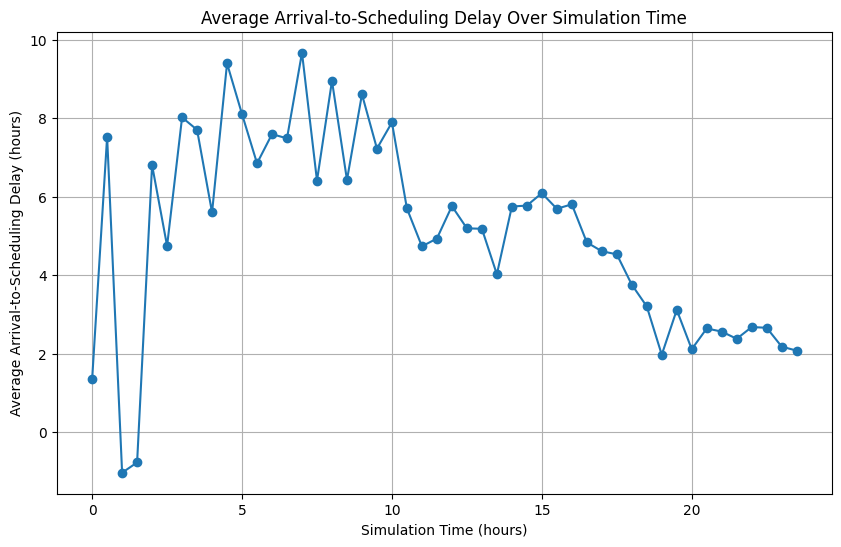

In [12]:
# Section 6: Arrival-to-Scheduling Delay

# Create a new column for delay: scheduled_start - arrival_time, if scheduled_start exists.
df_simulation_logs['arrival_to_schedule_delay'] = df_simulation_logs.apply(
    lambda row: row['scheduled_start'] - row['arrival_time'] if row['scheduled_start'] is not None else None,
    axis=1
)

# Group by simulation time and compute the average delay.
delay_metrics = df_simulation_logs.groupby('time').agg(
    avg_delay=('arrival_to_schedule_delay', 'mean')
).reset_index()

print("Arrival-to-Scheduling Delay Metrics by Time:")
print(delay_metrics)

# Plot the average arrival-to-scheduling delay over simulation time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(delay_metrics['time'], delay_metrics['avg_delay'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Average Arrival-to-Scheduling Delay (hours)')
plt.title('Average Arrival-to-Scheduling Delay Over Simulation Time')
plt.grid(True)
plt.show()


## Section 7: Resource Utilization Rate

In this section, we measure the **Resource Utilization Rate**, which reflects how effectively the available scheduling time is being used by tasks. In our simulation, we can approximate this metric by calculating the total duration of all scheduled tasks at a given simulation time step and comparing it to the available time remaining in the day (i.e., from the current simulation time until the end of the day). A higher ratio indicates that a larger portion of the remaining time is allocated to tasks.

### Explanation:
- **Total Task Duration:**  
  For each simulation time step, we sum the durations of all active tasks.
- **Available Scheduling Time:**  
  This is computed as the difference between the end of the day (`day_hours`) and the current simulation time.
- **Utilization Rate:**  
  We then calculate the ratio:
  
  \[
  \text{Utilization Rate} = \frac{\text{Total Duration of Scheduled Tasks}}{\text{Available Time}}
  \]
  
  Note that if the available time is very small (e.g., near the end of the day), the ratio might inflate; hence, this metric is most informative during the early and mid portions of the day.

<ipython-input-13-28badbc4ffdd>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  utilization = df.groupby('time').apply(


Resource Utilization Rate by Time:
    time  utilization_rate
0    0.0          0.066667
1    0.5          0.153191
2    1.0          0.326087
3    1.5          0.333333
4    2.0          0.731818
5    2.5          0.748837
6    3.0          0.690476
7    3.5          0.707317
8    4.0          1.240000
9    4.5          1.317949
10   5.0          1.394737
11   5.5          1.659459
12   6.0          1.672222
13   6.5          1.891429
14   7.0          2.029412
15   7.5          2.036364
16   8.0          2.100000
17   8.5          1.974194
18   9.0          1.900000
19   9.5          1.958621
20  10.0          2.135714
21  10.5          2.474074
22  11.0          2.692308
23  11.5          3.064000
24  12.0          3.175000
25  12.5          3.173913
26  13.0          3.536364
27  13.5          3.647619
28  14.0          3.820000
29  14.5          4.600000
30  15.0          4.255556
31  15.5          3.894118
32  16.0          3.900000
33  16.5          3.426667
34  17.0          3.

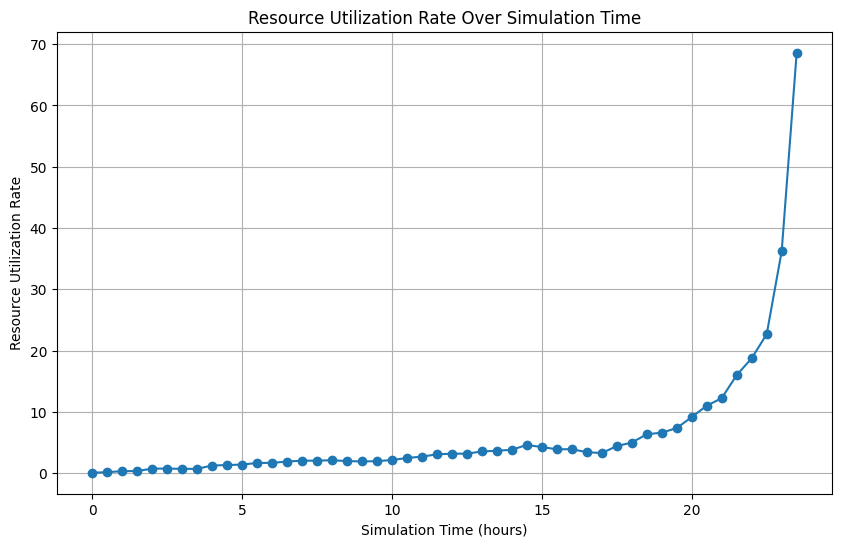

In [13]:
# Section 7: Resource Utilization Rate

def compute_resource_utilization(df, day_hours):
    """
    Compute the resource utilization rate at each simulation time step.

    For each simulation time step, the utilization rate is defined as:
      (Sum of durations for tasks at that time) / (Available time remaining in the day)

    Parameters:
      df (DataFrame): Simulation logs containing a 'time' and 'duration' column.
      day_hours (float): Total hours in the simulation day.

    Returns:
      utilization (DataFrame): DataFrame with columns 'time' and 'utilization_rate'.
    """
    utilization = df.groupby('time').apply(
        lambda group: group['duration'].sum() / (day_hours - group['time'].iloc[0]) if (day_hours - group['time'].iloc[0]) > 0 else 0
    ).reset_index(name='utilization_rate')
    return utilization

# Compute resource utilization metrics from the simulation logs.
utilization_metrics = compute_resource_utilization(df_simulation_logs, day_hours)

print("Resource Utilization Rate by Time:")
print(utilization_metrics)

# Plot the Resource Utilization Rate over simulation time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(utilization_metrics['time'], utilization_metrics['utilization_rate'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Resource Utilization Rate')
plt.title('Resource Utilization Rate Over Simulation Time')
plt.grid(True)
plt.show()


## Section 8: Task Rejection/Cancellation Rate

In this section, we assess the **Task Rejection/Cancellation Rate**. This metric indicates the percentage of tasks that are dropped (or cancelled) at each simulation step. In our simulation, tasks may be removed (canceled) if they become overdue or unschedulable. By comparing the number of tasks entering the system (from previous steps plus new tasks) to the number of tasks that remain active, we can calculate the cancellation rate.

### Explanation:
- **Total Input Tasks per Step:**  
  This is computed as the sum of tasks carried over from the previous simulation step and the new tasks added at the current step.
- **Cancellation Count:**  
  The number of tasks cancelled is the difference between the total input tasks and the number of tasks that remain active (i.e., scheduled tasks) in the current step.
- **Cancellation Rate:**  
  \[
  \text{Cancellation Rate} = \left(\frac{\text{Cancelled Tasks}}{\text{Total Input Tasks}}\right) \times 100\%
  \]
  A high cancellation rate may indicate that the system is frequently overwhelmed or that the constraints are too strict.

Task Rejection/Cancellation Metrics by Time:
    time  cancelled  total_input  cancellation_rate
0    0.0          0            2           0.000000
1    0.5          0            3           0.000000
2    1.0          0            5           0.000000
3    1.5          0            5           0.000000
4    2.0          0           11           0.000000
5    2.5          0           11           0.000000
6    3.0          2           11          18.181818
7    3.5          0            9           0.000000
8    4.0          0           15           0.000000
9    4.5          0           16           0.000000
10   5.0          1           18           5.555556
11   5.5          0           20           0.000000
12   6.0          1           20           5.000000
13   6.5          1           23           4.347826
14   7.0          1           24           4.166667
15   7.5          1           24           4.166667
16   8.0          0           23           0.000000
17   8.5          4

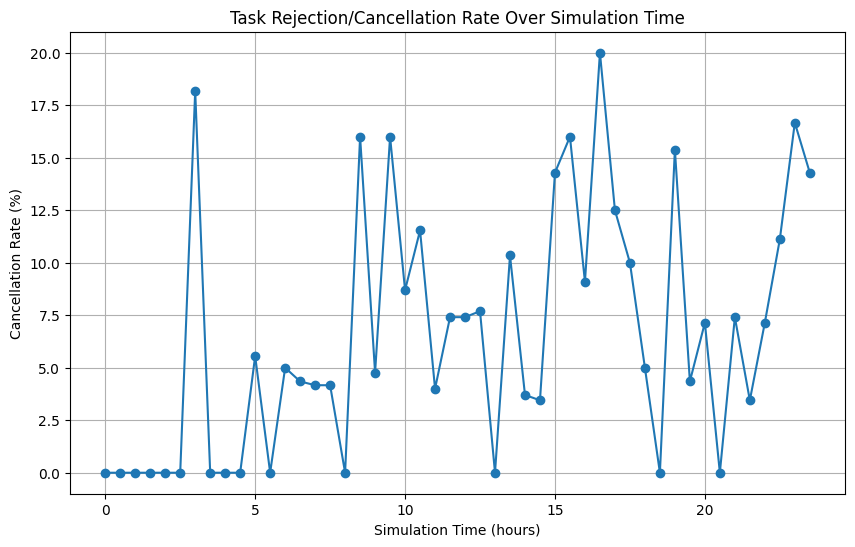

In [14]:
# Section 8: Task Rejection/Cancellation Rate

# We assume simulation_logs is a list of dictionaries, where each log entry contains:
# - 'time': simulation time,
# - 'num_tasks': number of tasks that remain after cancellation,
# - 'new_tasks': list of tasks that arrived at that time step.

cancellation_metrics = []
prev_total = 0  # Number of tasks carried over from the previous time step

for log in simulation_logs:
    new_count = len(log['new_tasks'])
    total_input = prev_total + new_count  # Total tasks entering at this time step
    current_count = log['num_tasks']  # Tasks that remain active after cancellation
    # Calculate number of cancelled tasks
    cancelled = total_input - current_count
    # Calculate cancellation rate (as a percentage)
    cancellation_rate = (cancelled / total_input) * 100 if total_input > 0 else 0
    cancellation_metrics.append({
        'time': log['time'],
        'cancelled': cancelled,
        'total_input': total_input,
        'cancellation_rate': cancellation_rate
    })
    prev_total = current_count  # Update for the next time step

# Convert the metrics into a DataFrame for easy analysis
df_cancellation = pd.DataFrame(cancellation_metrics)
print("Task Rejection/Cancellation Metrics by Time:")
print(df_cancellation)

# Plot the Cancellation Rate over simulation time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_cancellation['time'], df_cancellation['cancellation_rate'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Cancellation Rate (%)')
plt.title('Task Rejection/Cancellation Rate Over Simulation Time')
plt.grid(True)
plt.show()


## Section 9: Convergence & Swarm Diversity Metrics

In this section, we focus on two important aspects of our optimization process:

1. **Convergence Metrics:**  
   We track how the best objective (cost) value improves over the iterations of the optimizer. This tells us whether the optimizer is effectively homing in on an optimal solution and how quickly it converges.

2. **Swarm Diversity Metrics:**  
   We measure the diversity of candidate solutions within the swarm during each iteration. A higher diversity (e.g., measured as the average variance across candidate start times) helps ensure that the optimizer is exploring a broad range of solutions, whereas low diversity may indicate premature convergence to a suboptimal solution.

To capture these metrics, we modify our optimizer slightly to log the best cost and the diversity of the swarm at each iteration. Below is the code for the modified optimizer and a demonstration of how to plot these metrics.

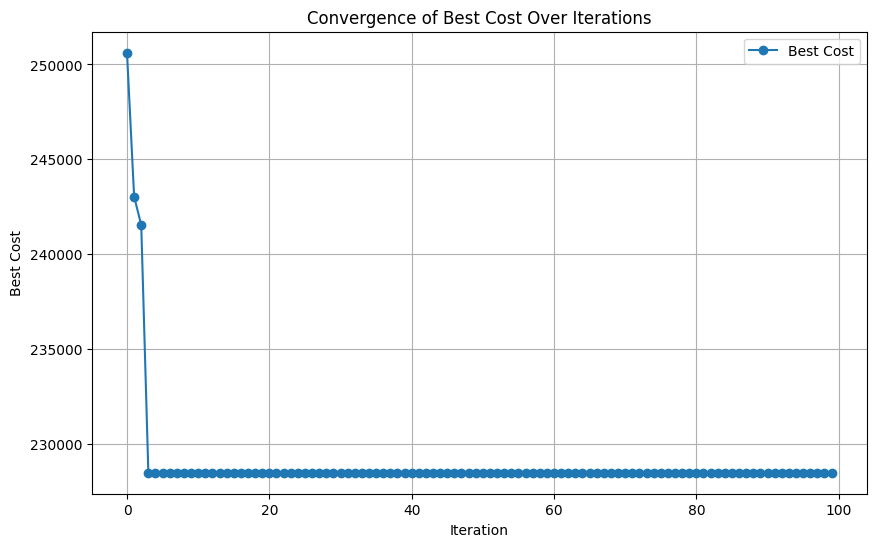

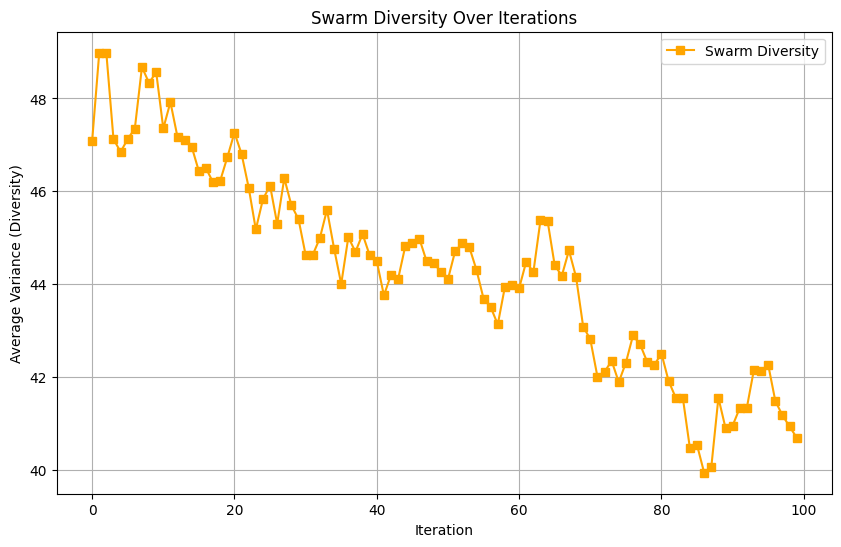

Convergence and diversity metrics logged.


In [15]:
def dynamic_harmonic_swarm_optimizer_with_logging(obj_func, tasks, current_time, swarm_size, iteration_count, harmonic_amplitude, harmonic_frequency):
    """
    A modified harmonic swarm optimizer that logs convergence and diversity metrics.

    Parameters:
      obj_func (function): The objective function to minimize.
      tasks (list): List of task dictionaries.
      current_time (float): The current simulation time.
      swarm_size (int): Number of candidate solutions.
      iteration_count (int): Total iterations to run.
      harmonic_amplitude (float): Amplitude for harmonic adjustment.
      harmonic_frequency (float): Frequency of harmonic modulation.

    Returns:
      best_solution (array): The candidate schedule (start times) with the lowest cost.
      best_cost (float): The cost associated with the best solution.
      convergence_log (list): Best cost at each iteration.
      diversity_log (list): Average variance (diversity) of the swarm at each iteration.
    """
    num_tasks = len(tasks)
    lower_bound = current_time
    upper_bound = day_hours
    swarm = np.random.uniform(low=lower_bound, high=upper_bound, size=(swarm_size, num_tasks))

    best_solution = None
    best_cost = float('inf')
    convergence_log = []
    diversity_log = []

    for iteration in range(iteration_count):
        # Evaluate each candidate solution.
        for candidate in swarm:
            cost = obj_func(candidate, tasks, current_time)
            if cost < best_cost:
                best_cost = cost
                best_solution = candidate.copy()

        # Log convergence: record the best cost so far.
        convergence_log.append(best_cost)

        # Log diversity: compute the average variance across each task (column) in the swarm.
        diversity = np.mean(np.var(swarm, axis=0))
        diversity_log.append(diversity)

        # Apply harmonic adjustment.
        harmonic_adjustment = harmonic_amplitude * np.sin(harmonic_frequency * iteration)
        swarm += harmonic_adjustment

        # Add random noise.
        noise = np.random.normal(loc=0.0, scale=0.7, size=swarm.shape)
        swarm += noise

        # Apply random scaling.
        random_scaling = np.random.uniform(0.8, 1.2, size=swarm.shape)
        swarm *= random_scaling

        # Ensure candidate solutions remain within bounds.
        swarm = np.clip(swarm, lower_bound, upper_bound)

    return best_solution, best_cost, convergence_log, diversity_log

# Example usage:
# For demonstration, we run the optimizer on the current set of tasks.
# (Assuming 'tasks' is non-empty; if not, please ensure tasks have been generated.)
if tasks:
    best_solution, best_cost, convergence_log, diversity_log = dynamic_harmonic_swarm_optimizer_with_logging(
        dynamic_objective_function,
        tasks,
        current_time=0,   # Example starting time for testing
        swarm_size=50,
        iteration_count=100,
        harmonic_amplitude=0.5,
        harmonic_frequency=1.0
    )

    # Plot convergence of best cost over iterations.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(convergence_log)), convergence_log, marker='o', label='Best Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.title('Convergence of Best Cost Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot swarm diversity (average variance) over iterations.
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(diversity_log)), diversity_log, marker='s', color='orange', label='Swarm Diversity')
    plt.xlabel('Iteration')
    plt.ylabel('Average Variance (Diversity)')
    plt.title('Swarm Diversity Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Convergence and diversity metrics logged.")
else:
    print("No tasks available for optimization. Please ensure tasks are generated before running the optimizer.")


## Section 10: Task Priority Distribution and Cost Contribution

In this section, we analyze the distribution of task priorities and how much each task contributes to the overall cost. Understanding these distributions helps us identify whether certain tasks are disproportionately affecting the schedule and whether the dynamic priority updates are working as expected.

### What We Analyze:
- **Task Priority Distribution:**  
  We visualize and summarize the statistical distribution of task priorities. This helps us see if most tasks fall within a reasonable range or if outliers (extremely high or low priorities) are skewing the optimization.
  
- **Task Cost Contribution Distribution:**  
  We also plot and summarize the cost contributions of tasks. This metric indicates how much each task’s scheduling (or mis-scheduling) is affecting the total objective cost, highlighting potential bottlenecks.

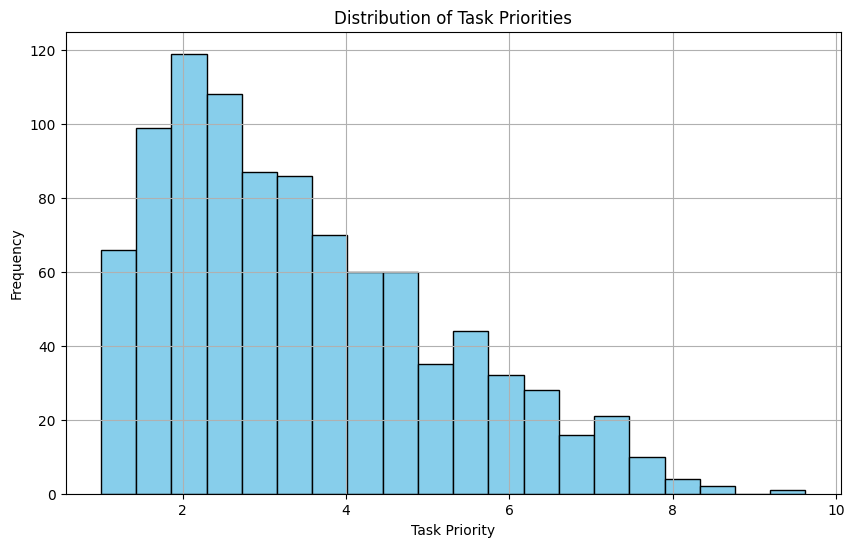

Task Priority Summary:
count    948.000000
mean       3.476174
std        1.681929
min        1.000000
25%        2.100000
50%        3.115666
75%        4.523344
max        9.622240
Name: priority, dtype: float64


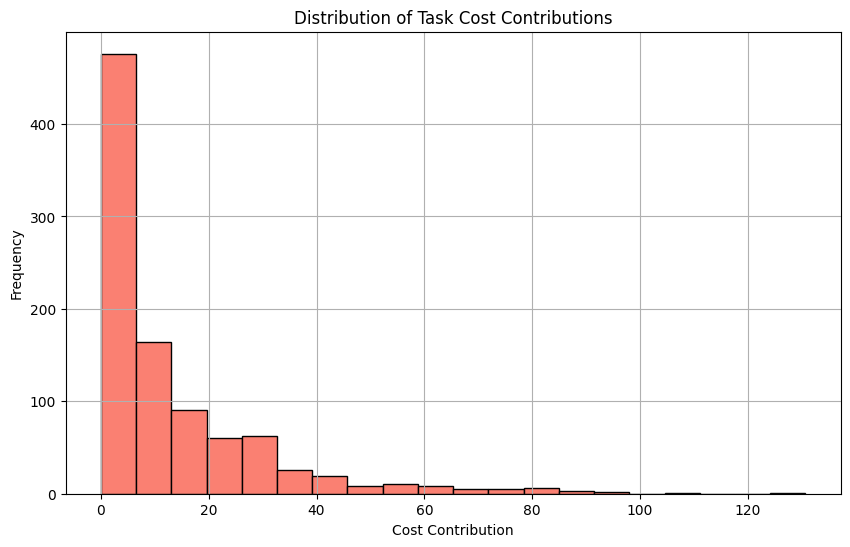

Task Cost Contribution Summary:
count    948.000000
mean      12.812431
std       17.155944
min        0.000000
25%        1.024918
50%        6.497914
75%       17.675332
max      130.682873
Name: cost_contribution, dtype: float64


In [16]:
# Section 10: Task Priority Distribution and Cost Contribution

import matplotlib.pyplot as plt

# Plot the histogram of task priorities.
plt.figure(figsize=(10, 6))
plt.hist(df_simulation_logs['priority'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Task Priority')
plt.ylabel('Frequency')
plt.title('Distribution of Task Priorities')
plt.grid(True)
plt.show()

# Display summary statistics for task priorities.
priority_summary = df_simulation_logs['priority'].describe()
print("Task Priority Summary:")
print(priority_summary)

# Plot the histogram of task cost contributions.
plt.figure(figsize=(10, 6))
plt.hist(df_simulation_logs['cost_contribution'].dropna(), bins=20, color='salmon', edgecolor='black')
plt.xlabel('Cost Contribution')
plt.ylabel('Frequency')
plt.title('Distribution of Task Cost Contributions')
plt.grid(True)
plt.show()

# Display summary statistics for cost contributions.
cost_contribution_summary = df_simulation_logs['cost_contribution'].describe()
print("Task Cost Contribution Summary:")
print(cost_contribution_summary)


## Section 11: Scheduling Stability and Impact of Bursty Arrivals

In this section, we analyze two aspects of our scheduling system:

1. **Scheduling Stability:**  
   We measure how much the scheduled start times change over consecutive simulation steps for tasks that persist.  
   - **Metric:** For each task that appears in successive time steps, compute the absolute difference in its scheduled start times.  
   - **Interpretation:** Lower differences indicate a more stable schedule over time.

2. **Impact of Bursty Arrivals:**  
   We examine how sudden bursts of new tasks affect the overall performance (aggregate cost) of the scheduler.
   - **Metric:** Compare the average aggregate cost during time steps with high numbers of new tasks (bursty periods) to periods with fewer new tasks.
   - **Interpretation:** A significant increase in aggregate cost during bursts may indicate that the system struggles under high load.

Average Scheduling Stability (mean absolute change in scheduled start times): 3.197695652173913


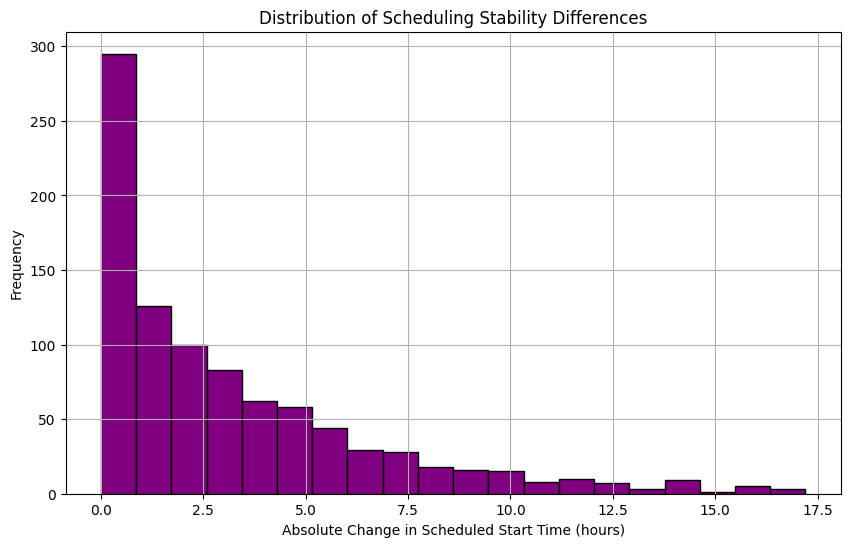

Average Aggregate Cost during Burst Periods: 70189.96600768426
Average Aggregate Cost during Non-Burst Periods: 49621.854039334314


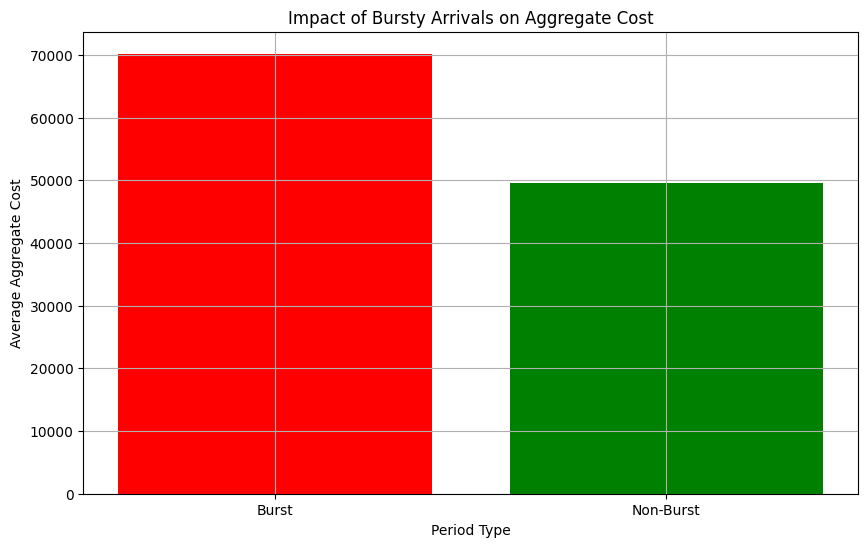

In [17]:
# Section 11: Scheduling Stability and Impact of Bursty Arrivals

import matplotlib.pyplot as plt

# -------------------------------
# Part A: Scheduling Stability

# For tasks that appear in consecutive simulation time steps, compute the absolute change in scheduled start times.
# First, sort the simulation logs by task_id and time.
df_sorted = df_simulation_logs.sort_values(by=['task_id', 'time'])

# Compute the previous scheduled start for each task.
df_sorted['prev_scheduled_start'] = df_sorted.groupby('task_id')['scheduled_start'].shift(1)

# Calculate the absolute difference (stability difference) in scheduled start times.
df_sorted['stability_diff'] = (df_sorted['scheduled_start'] - df_sorted['prev_scheduled_start']).abs()

# Compute the average scheduling change for tasks that persisted.
stability_metric = df_sorted['stability_diff'].mean()
print("Average Scheduling Stability (mean absolute change in scheduled start times):", stability_metric)

# Plot the distribution of scheduling stability differences.
plt.figure(figsize=(10, 6))
plt.hist(df_sorted['stability_diff'].dropna(), bins=20, color='purple', edgecolor='black')
plt.xlabel('Absolute Change in Scheduled Start Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Scheduling Stability Differences')
plt.grid(True)
plt.show()


# -------------------------------
# Part B: Impact of Bursty Arrivals

# Extract burst metrics from simulation logs.
burst_metrics = []
for log in simulation_logs:
    new_task_count = len(log['new_tasks'])
    burst_metrics.append({
        'time': log['time'],
        'new_task_count': new_task_count,
        'aggregate_cost': log['aggregate_cost']
    })

df_burst = pd.DataFrame(burst_metrics)

# Define a threshold for what constitutes a burst (e.g., more than 2 new tasks).
burst_threshold = 2
df_burst['burst'] = df_burst['new_task_count'] > burst_threshold

# Calculate average aggregate cost for burst vs. non-burst periods.
burst_cost = df_burst[df_burst['burst']]['aggregate_cost'].mean()
non_burst_cost = df_burst[~df_burst['burst']]['aggregate_cost'].mean()

print("Average Aggregate Cost during Burst Periods:", burst_cost)
print("Average Aggregate Cost during Non-Burst Periods:", non_burst_cost)

# Visualize the impact of burst arrivals on aggregate cost.
plt.figure(figsize=(10, 6))
plt.bar(['Burst', 'Non-Burst'], [burst_cost, non_burst_cost], color=['red', 'green'])
plt.xlabel('Period Type')
plt.ylabel('Average Aggregate Cost')
plt.title('Impact of Bursty Arrivals on Aggregate Cost')
plt.grid(True)
plt.show()


## Section 12: Allowed Window Violation Frequency

In this section, we measure how frequently tasks are scheduled outside their designated allowed window. This metric—expressed as a percentage—indicates the adherence of the scheduler to the time window constraints. A high violation frequency suggests that many tasks are being scheduled at times that fall outside their intended time slots (e.g., outside office hours), which may necessitate adjustments to the penalty weights or the scheduling strategy.

### What We Do:
- **Violation Detection:**  
  For each task, we determine if its scheduled start time lies outside its allowed window. If it does, it is flagged as a violation.
  
- **Frequency Calculation:**  
  At each simulation time step, we calculate the ratio of tasks that violate their allowed window to the total number of tasks, and express this ratio as a percentage.

Allowed Window Violation Frequency by Time:
    time  violation_frequency
0    0.0            50.000000
1    0.5            33.333333
2    1.0            60.000000
3    1.5            60.000000
4    2.0            45.454545
5    2.5            27.272727
6    3.0            55.555556
7    3.5            33.333333
8    4.0            60.000000
9    4.5            43.750000
10   5.0            64.705882
11   5.5            65.000000
12   6.0            36.842105
13   6.5            72.727273
14   7.0            65.217391
15   7.5            56.521739
16   8.0            65.217391
17   8.5            47.619048
18   9.0            45.000000
19   9.5            47.619048
20  10.0            52.380952
21  10.5            43.478261
22  11.0            41.666667
23  11.5            52.000000
24  12.0            52.000000
25  12.5            58.333333
26  13.0            48.148148
27  13.5            42.307692
28  14.0            50.000000
29  14.5            50.000000
30  15.0            62.500

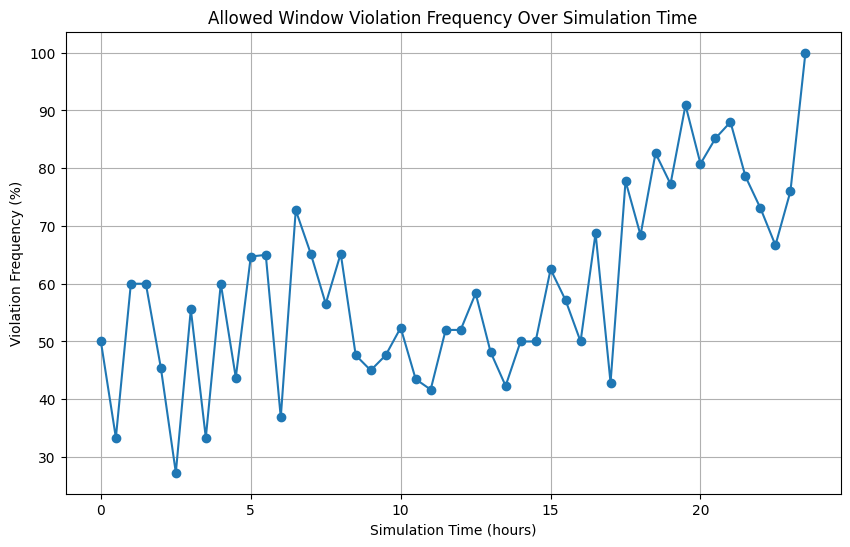

In [18]:
# Section 12: Allowed Window Violation Frequency

def is_violating_allowed_window(row):
    """
    Check if the task's scheduled start time falls outside its allowed window.
    Returns 1 if the scheduled start time is outside the allowed window, else 0.
    """
    if 'allowed_window' in row and row['scheduled_start'] is not None:
        window_start, window_end = row['allowed_window']
        if row['scheduled_start'] < window_start or row['scheduled_start'] > window_end:
            return 1
    return 0

# Apply the function to flag violations in the DataFrame.
df_simulation_logs['allowed_window_violation'] = df_simulation_logs.apply(is_violating_allowed_window, axis=1)

# Group by simulation time to compute the percentage of tasks violating their allowed window.
allowed_window_violations = df_simulation_logs.groupby('time').agg(
    total_tasks=('task_id', 'count'),
    total_violations=('allowed_window_violation', 'sum')
).reset_index()

allowed_window_violations['violation_frequency'] = (allowed_window_violations['total_violations'] / allowed_window_violations['total_tasks']) * 100

print("Allowed Window Violation Frequency by Time:")
print(allowed_window_violations[['time', 'violation_frequency']])

# Plot the Allowed Window Violation Frequency over simulation time.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(allowed_window_violations['time'], allowed_window_violations['violation_frequency'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Violation Frequency (%)')
plt.title('Allowed Window Violation Frequency Over Simulation Time')
plt.grid(True)
plt.show()


## Section 13: Optimization Computation Time & System Responsiveness

In this section, we quantify two important aspects related to the performance of our scheduling system:

1. **Optimization Computation Time:**  
   This metric measures how long it takes for the optimizer (the harmonic swarm algorithm) to compute an optimal schedule at each simulation step. Lower computation times are critical for real-time applications. We can track these times to assess if our optimizer is efficient enough and to identify bottlenecks.

2. **System Responsiveness:**  
   Although we already measured the "Arrival-to-Scheduling Delay" in Section 6, system responsiveness can also be reflected in how quickly the optimizer reacts to new tasks and updates the schedule. In practice, this is linked to the computation time, so improvements in computation time will also enhance responsiveness.

Below is the sample code that demonstrates how to measure the optimization computation time during each simulation step. This example uses Python's `time` module to capture the duration of each optimization call. The results are then plotted over the simulation time.

> **Note:**  
> In an actual implementation, you would integrate the time measurements directly within your simulation loop. For demonstration purposes, we simulate a simplified loop here.

Optimization Computation Time Metrics (first few rows):
   time  optimization_time
0   0.0           0.168259
1   0.5           0.166079
2   1.0           0.158353
3   1.5           0.155523
4   2.0           0.167099


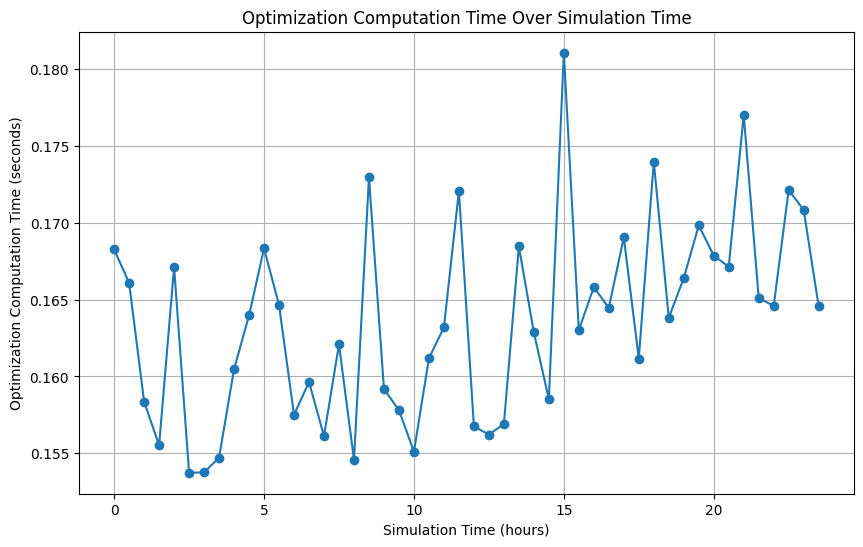

In [19]:
# Section 13: Optimization Computation Time & System Responsiveness

import time
import matplotlib.pyplot as plt

# For demonstration, we simulate measurement of optimization time.
# We'll assume 'tasks' is already defined and populated in the simulation context.
# The following loop simulates measurement for each simulation time step.

simulation_times = []
optimization_times = []

# Example parameters for the optimizer
swarm_size = 50
iteration_count = 100
harmonic_amplitude = 0.5
harmonic_frequency = 1.0

# We simulate over the same number of time steps as our simulation.
for step in range(num_steps):
    current_time = round(step * time_step, 1)

    # Start time measurement
    start_opt_time = time.time()

    # Call the optimizer only if there are tasks; otherwise, skip.
    if tasks:
        best_schedule, best_cost = dynamic_harmonic_swarm_optimizer(
            dynamic_objective_function,
            tasks,
            current_time,
            swarm_size,
            iteration_count,
            harmonic_amplitude,
            harmonic_frequency
        )
    else:
        # Simulate a negligible optimization time when no tasks are present.
        best_schedule, best_cost = None, None

    # End time measurement
    end_opt_time = time.time()
    optimization_duration = end_opt_time - start_opt_time

    simulation_times.append(current_time)
    optimization_times.append(optimization_duration)

# Create a DataFrame to store the optimization times per simulation step.
df_opt = pd.DataFrame({
    'time': simulation_times,
    'optimization_time': optimization_times
})

print("Optimization Computation Time Metrics (first few rows):")
print(df_opt.head())

# Plot the optimization computation time over simulation time.
plt.figure(figsize=(10, 6))
plt.plot(df_opt['time'], df_opt['optimization_time'], marker='o', linestyle='-')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Optimization Computation Time (seconds)')
plt.title('Optimization Computation Time Over Simulation Time')
plt.grid(True)
plt.show()

# Note: System responsiveness is also reflected in the Arrival-to-Scheduling Delay metric
# computed in Section 6. Faster optimization times improve overall system responsiveness.


## Section 14: Conclusion and Next Steps

In this final section, we summarize the insights gained from our dynamic scheduling simulation and outline actionable next steps. By measuring an exhaustive set of metrics—from aggregate cost and lateness to resource utilization and system responsiveness—we can holistically evaluate the performance of our scheduling system. These metrics not only pinpoint areas for improvement (e.g., handling bursty arrivals or improving convergence) but also guide the fine-tuning of algorithm parameters.

### Key Takeaways:
- **Performance Monitoring:**  
  The simulation logs provide detailed insights into the overall scheduling performance, including how well the system meets deadlines and respects allowed time windows.
  
- **Optimization Quality:**  
  Convergence and diversity metrics help assess whether the harmonic swarm optimizer effectively explores the solution space and converges to a robust solution.
  
- **System Responsiveness:**  
  Measuring optimization computation time and arrival-to-scheduling delays reveals how quickly the system adapts to new tasks, which is crucial for real-time applications.
  
- **Actionable Metrics:**  
  Metrics such as task cancellation rate, resource utilization, and allowed window violations offer practical guidance for improving scheduling quality and efficiency.

### Next Steps:
1. **Parameter Tuning:**  
   Based on the observed metrics, adjust parameters (e.g., penalty weights, swarm size, iteration count, and noise levels) to optimize performance under various conditions.
2. **Algorithm Enhancements:**  
   Consider incorporating additional strategies (e.g., smoothing mechanisms or fallback scheduling for burst periods) to improve stability and robustness.
3. **Real-World Validation:**  
   Test the simulation on real-world data and scenarios to validate the effectiveness of the scheduling approach.
4. **Reporting and Dashboarding:**  
   Develop a dashboard that displays these metrics in real time, allowing continuous monitoring and proactive management of scheduling performance.
5. **Iterative Improvements:**  
   Use the actionable metrics to iteratively refine the simulation and the optimization algorithm, ensuring it scales well under diverse and dynamic conditions.

In [20]:
# Section 14: Conclusion and Next Steps

def summarize_simulation():
    print("Dynamic Scheduling Simulation Summary:")
    print("- Total simulation duration: {} hours".format(day_hours))
    print("- Total number of simulation steps: {}".format(num_steps))
    print("- Check the generated logs (dynamic_scheduling_with_time_windows_logs.csv) for detailed insights.")
    print("\nNext Steps:")
    print("1. Fine-tune algorithm parameters based on observed metrics (e.g., penalty weights, swarm size).")
    print("2. Enhance the optimizer to better handle bursty task arrivals and boundary issues.")
    print("3. Integrate real-world data to validate and adjust the simulation model.")
    print("4. Develop a live dashboard for continuous monitoring of scheduling performance.")

# Print the summary
summarize_simulation()


Dynamic Scheduling Simulation Summary:
- Total simulation duration: 24 hours
- Total number of simulation steps: 48
- Check the generated logs (dynamic_scheduling_with_time_windows_logs.csv) for detailed insights.

Next Steps:
1. Fine-tune algorithm parameters based on observed metrics (e.g., penalty weights, swarm size).
2. Enhance the optimizer to better handle bursty task arrivals and boundary issues.
3. Integrate real-world data to validate and adjust the simulation model.
4. Develop a live dashboard for continuous monitoring of scheduling performance.
